In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
import operator
import os
from datetime import datetime
from enum import Enum
from typing import Optional, TypedDict

from langchain_core.messages import AnyMessage, ToolMessage
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field
from typing_extensions import Annotated, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI

ModuleNotFoundError: No module named 'langchain.messages'

In [ ]:
class Action(str, Enum):
    CREATE_CLIENT = "create_client"
    UPDATE_CLIENT = "update_client"
    CREATE_JOB = "create_job"
    UPDATE_JOB = "update_job"
    EXTRACT = "extract"
    UNKNOWN = "unknown"
    

class Subject(str, Enum):
    CLIENT = "client"
    JOB = "job"

class JobStatus(str, Enum):
    PENDING = "pending"
    IN_PROGRESS = "in_progress"
    COMPLETED = "completed"

In [ ]:
class Step(BaseModel):
    sub_command: Optional[str] = Field(description="A specific sub command to execute.")
    action: Action = Field(description="The action to perform.")
    # justification: Optional[str] = Field(description="A brief explanation of why this step has such action type.")

In [ ]:
class Plan(BaseModel):
    steps: list[Step] = Field(
        description="A detailed, multi-step plan to execute the user's command."
    )

In [ ]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    plan: Plan
    current_step_index: int
    command: str
    object_id: Optional[str]
    client_id: str
    job_ids: list[str]
    # action: Action
    # subject: Subject

In [ ]:
class Client(BaseModel):
    id: str | None = Field(None, description="Unique identifier for the client")
    name: str | None = Field(None, description="Name of the customer")
    email: str | None = Field(None, description="Email of the customer")
    phone: str | None = Field(None, description="Phone of the customer")


class Job(BaseModel):
    id: str | None = Field(None, description="Unique identifier for the job")
    client_id: str | None = Field(
        None, description="Identifier of the client that owns the job"
    )
    title: str | None = Field(None, description="Title of the job")
    description: str | None = Field(None, description="Description of the job")
    location: str | None = Field(None, description="Location of the job")
    status: JobStatus | None = Field(None, description="Status of the job")
    start_date: datetime | None = Field(None, description="Start date of the job")
    end_date: datetime | None = Field(None, description="End date of the job")

In [ ]:
# Define tools
@tool(args_schema=Client)
async def create_client(
    name: str | None = None,
    email: str | None = None,
    phone: str | None = None,
    **kwargs,
) -> None:
    """Create client in the database.

    name: Name of the customer.
    email: Email of the customer.
    phone: Phone of the customer

    """
    print(f"INSERT INTO client (name, email, phone) VALUES ({name}, {email}, {phone})")
    return "client_123"


@tool(args_schema=Client)
async def update_client(
    id: str,
    name: str | None = None,
    email: str | None = None,
    phone: str | None = None,
    **kwargs,
) -> None:
    """Update client in the database.

    id: Unique identifier for the client.
    name: Name of the customer.
    email: Email of the customer.
    phone: Phone of the customer

    """
    fields = ["name", "email", "phone"]
    values = [name, email, phone]
    update_values = ", ".join(
        [f"{f} = {v}" for f, v in zip(fields, values) if v is not None]
    )

    return f"UPDATE client SET {update_values} WHERE client_id = {id}"


@tool(args_schema=Job)
async def create_job(
    client_id: str | None = None,
    title: str | None = None,
    description: str | None = None,
    location: str | None = None,
    status: str | None = None,
    start_date: datetime | None = None,
    end_date: datetime | None = None,
    **kwargs,
) -> str:
    """Create job in the database.

    client_id: Identifier of the client that owns the job
    title: Title of the job
    description: Description of the job
    location: Location of the job
    status: Status of the job
    start_date: Start date of the job
    end_date: End date of the job

    """
    print(
        (
            "INSERT INTO job (client_id, title, description, location, status, start_date, end_date)\n"
            f"VALUES ({client_id}, {title}, {description}, {location}, {status}, {start_date}, {end_date})"
        )
    )

    return "job_123"


@tool(args_schema=Job)
async def update_job(
    id: str,
    client_id: str | None = None,
    title: str | None = None,
    description: str | None = None,
    location: str | None = None,
    status: str | None = None,
    start_date: datetime | None = None,
    end_date: datetime | None = None,
    **kwargs,
) -> str:
    """Updates the given subject with the provided fields and values.

    id: Unique identifier for the job.
    client_id: Identifier of the client that owns the job.
    title: Title of the job
    description: Description of the job
    location: Location of the job
    status: Status of the job
    start_date: Start date of the job
    end_date: End date of the job

    """
    fields = [
        "client_id",
        "title",
        "description",
        "location",
        "status",
        "start_date",
        "end_date",
    ]
    values = [client_id, title, description, location, status, start_date, end_date]

    return (
        f"UPDATE job "
        f"SET ({', '.join(f'{f}={v}' for f, v in zip(fields, values) if v is not None)}) "
        f"WHERE job_id = {id}"
    )


@tool
async def extract(subject: BaseModel) -> dict:
    """Extracts data fields from the given subject.
    subject: The subject to extract data from.

    """

    print(f"EXTRACT data: {subject.model_dump_json()}")
    return {}

In [ ]:
# model = ChatOpenAI(model="gpt-4o", streaming=False)
model = ChatGoogleGenerativeAI(
    model="gemini-3-pro-preview",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# Augment the LLM with tools
tools = [create_client, update_client, create_job, update_job, extract]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [ ]:
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert planner. Your task is to create a clear, multi-step plan to execute a complex user command."
            "There are two main subjects: clients and jobs.\n"
            "There are five main actions: create_client, update_client, create_job, update_job, extract.\n"
            "You are given a complex command and you need to decompose the command to a series of simple, sequential sub-commands."
            "You need to rewrite subcommands with enough information about action and necessary data fields."
            # "For each step, rewrite to describe the appropriate action to take and any necessary data fields."
            "Just say you do not know if you cannot find any step to execute the command.",
        ),
        ("human", "User Query: {command}. Current client_id: {client_id}. List of job ids: {job_ids}"),  # The user's original, complex query
    ]
)

In [ ]:
# planner_llm = ChatOpenAI(model="gpt-4o", streaming=False)
planner_llm = ChatGoogleGenerativeAI(
    model="gemini-3-pro-preview",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [ ]:
complex_query_adv = (
    "Create a new client name Kien with the email abc@test.com."
    "Also create a job for this client with location in Hanoi and status pending."
)

client_id = None
job_ids = []

In [ ]:
planner_agent = planner_prompt | planner_llm.with_structured_output(Plan)

In [ ]:
async def plan_node(state: State) -> dict:
    # if state.get("plan") is not None:
    #     return {}

    plan = await planner_agent.ainvoke(
        {
            "command": state["command"],
            "client_id": state["client_id"],
            "job_ids": state["job_ids"],
        }
    )

    return {
        "messages": [("ai", f"Generated plan: {plan}")],
        "plan": plan,
        "current_step_index": 0,
    }

In [ ]:
from typing import Literal
from langgraph.types import interrupt, Command

In [ ]:
async def approval_node(state: State) -> Command[Literal["proceed", "retry", "cancel"]]:
    # Pause execution; payload shows up under result["__interrupt__"]
    is_approved = interrupt({
        "question": "Do you want to proceed with this plan?",
        "details": state["plan"]
    })

    # Route based on the response
    if is_approved == "proceed":
        return Command(goto="proceed")
    elif is_approved == "retry":
        return Command(goto="retry")
    else:
        return Command(goto="cancel")

In [ ]:
async def proceed_node(state: State):
    return {}

async def retry_node(state: State):
    return {}

async def cancel_node(state: State):
    return {}

In [ ]:
# Define the function that determines whether to continue or not
def route_step(state: State) -> str:
    if state["current_step_index"] >= len(state["plan"].steps):
        return "end"
    current_step = state["plan"].steps[state["current_step_index"]]
    if current_step.action == Action.UNKNOWN:
        return "end"
    return "continue"    

In [ ]:
# Define the function that calls the model to execute the action
system_prompt = (
    "You are a helpful assistant for a service that manages clients/customers and jobs need to be fullfiled for the client.\n"
    "You role is to understand commands and translates them into actions.\n"
    "There are two main subjects: clients and jobs.\n"
    "There are five main actions: create_client, update_client, create_job, update_job, extract.\n"
    "You are given a command and you need to determine the appropriate action to take and any necessary data fields.\n"
    "Please answer you do not konw if you are unsure about the command.\n"
)

human_prompt = (
    "Command: {command}. Current client_id: {client_id}. List of job ids: {job_ids}."
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

async def call_model_to_get_action(state: State):
    current_step = state["plan"].steps[state["current_step_index"]]
    command = current_step.sub_command
    chain = prompt | model_with_tools
    response = await chain.ainvoke(
        {
            "command": command,
            "client_id": state["client_id"],
            "job_ids": state["job_ids"],
        }
    )

    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


async def tool_node(state: State):
    tool_call = state["messages"][-1].tool_calls[0]
    tool = tools_by_name[tool_call["name"]]
    
    result = await tool.ainvoke(tool_call["args"])

    new_state = {
        "messages": [ToolMessage(content=result, tool_call_id=tool_call["id"])],
        "current_step_index": state["current_step_index"] + 1,
    }
    job_ids = state["job_ids"].copy()

    if tool.name == "create_client":
        new_state["client_id"] = result
    elif tool.name == "create_job":
        job_ids.append(result)
        new_state["job_ids"] = job_ids

    return new_state


async def end_node(state: State):
    messages = state["messages"]
    last_message = messages[-1] if messages else None
    print(last_message)
    if last_message and getattr(last_message, "content", None):
        print("Finish with message:", last_message.content)
        return {"messages": [("ai", last_message.content)]}
    return {"messages": [("ai", "Unknown response.")]}

In [ ]:
# Define the function that determines whether to continue or not
def should_continue_to_action(state: State) -> str:
    messages = state["messages"]
    last_message = messages[-1] if messages else None

    if not last_message:
        return "continue"
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [ ]:
def should_continue_to_plan(state: State) -> str:
    current_step_index = state["current_step_index"]
    if current_step_index >= len(state["plan"].steps):
        return "end"
    else:
        return "continue"

In [ ]:
workflow = StateGraph(State)

In [ ]:
workflow.add_node("plan", plan_node)
workflow.add_node("approval", approval_node)
workflow.add_node("proceed", proceed_node)
workflow.add_node("retry", retry_node)
workflow.add_node("cancel", cancel_node)
workflow.add_node("understand_command", call_model_to_get_action)
workflow.add_node("action", tool_node)
workflow.add_node("finish", end_node)

In [ ]:
workflow.set_entry_point("plan")
workflow.add_edge("plan", "approval")
workflow.add_edge("retry", "plan")
workflow.add_edge("cancel", END)

workflow.add_conditional_edges(
    "proceed",
    route_step,
    {
        "continue": "understand_command",
        "end": "finish",
    },
)

workflow.add_conditional_edges(
    "understand_command",
    should_continue_to_action,
    {
        "continue": "action",
        "end": "finish",
    },
)

workflow.add_conditional_edges(
    "action",
    should_continue_to_plan,
    {
        "continue": "proceed",
        "end": "finish",
    },
)

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

In [ ]:
# Use a more durable checkpointer in production
checkpointer = MemorySaver()

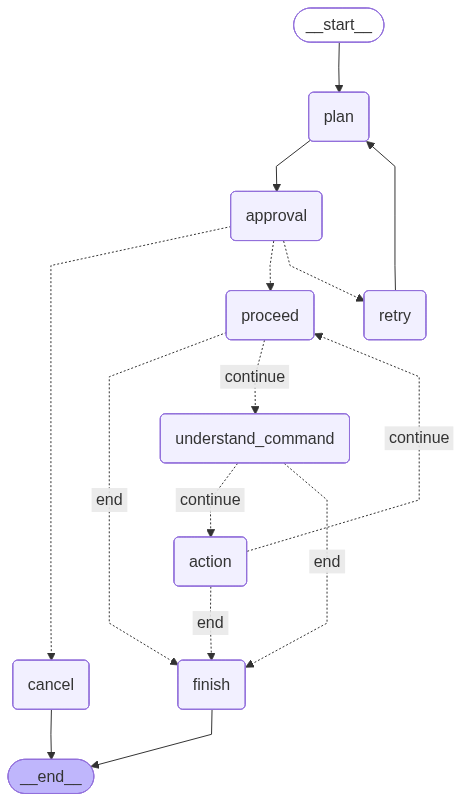

In [ ]:
graph = workflow.compile(checkpointer=checkpointer)
graph

In [ ]:
config = {"configurable": {"thread_id": "approval-123"}}

In [ ]:
result = await graph.ainvoke(
    {"command": complex_query_adv, "client_id": None, "job_ids": []},
    config=config,
)

In [ ]:
result

{'messages': [('ai',
   "Generated plan: steps=[Step(sub_command='Create client Kien with email abc@test.com', action=<Action.CREATE_CLIENT: 'create_client'>), Step(sub_command='Create job for client Kien with location Hanoi and status pending', action=<Action.CREATE_JOB: 'create_job'>)]")],
 'plan': Plan(steps=[Step(sub_command='Create client Kien with email abc@test.com', action=<Action.CREATE_CLIENT: 'create_client'>), Step(sub_command='Create job for client Kien with location Hanoi and status pending', action=<Action.CREATE_JOB: 'create_job'>)]),
 'current_step_index': 0,
 'command': 'Create a new client name Kien with the email abc@test.com.Also create a job for this client with location in Hanoi and status pending.',
 'client_id': None,
 'job_ids': [],
 '__interrupt__': [Interrupt(value={'question': 'Do you want to proceed with this plan?', 'details': Plan(steps=[Step(sub_command='Create client Kien with email abc@test.com', action=<Action.CREATE_CLIENT: 'create_client'>), Step(s

In [ ]:
result["__interrupt__"]

[Interrupt(value={'question': 'Do you want to proceed with this plan?', 'details': Plan(steps=[Step(sub_command='Create client Kien with email abc@test.com', action=<Action.CREATE_CLIENT: 'create_client'>), Step(sub_command='Create job for client Kien with location Hanoi and status pending', action=<Action.CREATE_JOB: 'create_job'>)])}, id='6153dfc56f7a8f5a3af70b0fc67b1b6a')]

In [ ]:
resumed = await graph.ainvoke(Command(resume="proceed"), config=config)

INSERT INTO client (name, email, phone) VALUES (Kien, abc@test.com, None)
INSERT INTO job (client_id, title, description, location, status, start_date, end_date)
VALUES (client_123, None, None, Hanoi, JobStatus.PENDING, None, None)
content='job_123' tool_call_id='50a1b4e9-3afa-4a2e-b29d-2eae3b4bd042'
Finish with message: job_123


In [ ]:
resumed

{'messages': [['ai',
   "Generated plan: steps=[Step(sub_command='Create client Kien with email abc@test.com', action=<Action.CREATE_CLIENT: 'create_client'>), Step(sub_command='Create job for client Kien with location Hanoi and status pending', action=<Action.CREATE_JOB: 'create_job'>)]"],
  AIMessage(content=[], additional_kwargs={'function_call': {'name': 'create_client', 'arguments': '{"email": "abc@test.com", "name": "Kien"}'}, '__gemini_function_call_thought_signatures__': {'77c77818-8773-435c-a3cf-b20674de432f': 'EocECoQEAXLI2nw3SxtMVF8PSKJAdmkUY9SmSeIP0ubCxBjLaJO8F4YAnSQuhJqH0gaQ2gHjbc+gEmaKKhd3RwL63qxN0mhUxfImwLVchNu8uMdPoBp5phP7lwQn/Q/urhrA/LqDrU/drcmNo8A4OjdbX+V7O9SEyOWwxdSFdAJLVVAVA8z/O4WGhA2fGJfOTbxeegWVTninqobDPvSPYsfNLrwHrCLDwrv65w6VKhLALcKbtlV3YMK8T4VvVjEivs6SCReDcXtR6n4w2bb+k9/Sel5rT0m46ZEDLy3WS70Ntqi1aXNEILA0wnQfQ07XiGhUBx9LG3GkVhgm/r3OvLnpP/kbQAmehCYMb4dhLWZxXtgiFFuS0PORSp2RU0VLB18YHLHR1J/s64bzlvqODlMfzBrOqvTgO6M1AFBDafstHrNSPJFd8yzJh3nIgXcL5cXKISWQO1sYJKh69+RzMpY4VM

In [ ]:
command = "Update start date and end date of job_123 to 2025-12-01 and 2025-12-03"
client_id = resumed["client_id"]
job_ids = resumed["job_ids"]
config = {"configurable": {"thread_id": "approval-234"}}

In [ ]:
result2 = await graph.ainvoke(
    {"command": command, "client_id": client_id, "job_ids": job_ids}, config=config
)

In [ ]:
result2

{'messages': [('ai',
   'Generated plan: steps=[Step(sub_command="Update job_123 with start_date=\'2025-12-01\' and end_date=\'2025-12-03\'", action=<Action.UPDATE_JOB: \'update_job\'>)]')],
 'plan': Plan(steps=[Step(sub_command="Update job_123 with start_date='2025-12-01' and end_date='2025-12-03'", action=<Action.UPDATE_JOB: 'update_job'>)]),
 'current_step_index': 0,
 'command': 'Update start date and end date of job_123 to 2025-12-01 and 2025-12-03',
 'client_id': 'client_123',
 'job_ids': ['job_123'],
 '__interrupt__': [Interrupt(value={'question': 'Do you want to proceed with this plan?', 'details': Plan(steps=[Step(sub_command="Update job_123 with start_date='2025-12-01' and end_date='2025-12-03'", action=<Action.UPDATE_JOB: 'update_job'>)])}, id='5077575d581a1a1990ce1647b27a349a')]}

In [ ]:
resumed2 = await graph.ainvoke(Command(resume="retry"), config=config)

In [ ]:
resumed2

{'messages': [['ai',
   'Generated plan: steps=[Step(sub_command="Update job_123 with start_date=\'2025-12-01\' and end_date=\'2025-12-03\'", action=<Action.UPDATE_JOB: \'update_job\'>)]'],
  ('ai',
   'Generated plan: steps=[Step(sub_command="Update job_123 with start_date=\'2025-12-01\' and end_date=\'2025-12-03\'", action=<Action.UPDATE_JOB: \'update_job\'>)]')],
 'plan': Plan(steps=[Step(sub_command="Update job_123 with start_date='2025-12-01' and end_date='2025-12-03'", action=<Action.UPDATE_JOB: 'update_job'>)]),
 'current_step_index': 0,
 'command': 'Update start date and end date of job_123 to 2025-12-01 and 2025-12-03',
 'client_id': 'client_123',
 'job_ids': ['job_123'],
 '__interrupt__': [Interrupt(value={'question': 'Do you want to proceed with this plan?', 'details': Plan(steps=[Step(sub_command="Update job_123 with start_date='2025-12-01' and end_date='2025-12-03'", action=<Action.UPDATE_JOB: 'update_job'>)])}, id='d29d11d02dd9065e68792429b967a5bd')]}

In [ ]:
resumed3 = await graph.ainvoke(Command(resume="cancel"), config=config)
resumed3

{'messages': [['ai',
   'Generated plan: steps=[Step(sub_command="Update job_123 with start_date=\'2025-12-01\' and end_date=\'2025-12-03\'", action=<Action.UPDATE_JOB: \'update_job\'>)]'],
  ['ai',
   'Generated plan: steps=[Step(sub_command="Update job_123 with start_date=\'2025-12-01\' and end_date=\'2025-12-03\'", action=<Action.UPDATE_JOB: \'update_job\'>)]']],
 'plan': Plan(steps=[Step(sub_command="Update job_123 with start_date='2025-12-01' and end_date='2025-12-03'", action=<Action.UPDATE_JOB: 'update_job'>)]),
 'current_step_index': 0,
 'command': 'Update start date and end date of job_123 to 2025-12-01 and 2025-12-03',
 'client_id': 'client_123',
 'job_ids': ['job_123']}